# Work in progress

In [25]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
import scipy.io
from pymatreader import read_mat
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

#seeds for reproducibility
np.random.seed(40)
torch.manual_seed(40)

In [4]:
data = pd.read_csv('./dataset/combined_data.csv')
#dropping the columns that are not required like the filepath
data = data.drop(['matFilePath'], axis=1)
data = data.drop(['Motor5Cmd'], axis=1) #to confirm, why 0 for all rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Timestamps            float64
 1   Motor1Cmd             float64
 2   Motor2Cmd             float64
 3   Motor3Cmd             float64
 4   Motor4Cmd             float64
 5   DesiredTrajectory-x   float64
 6   DesiredTrajectory-y   float64
 7   DesiredTrajectory-z   float64
 8   RealizedTrajectory-x  float64
 9   RealizedTrajectory-y  float64
 10  RealizedTrajectory-z  float64
 11  Target                object 
dtypes: float64(11), object(1)
memory usage: 329.6+ MB


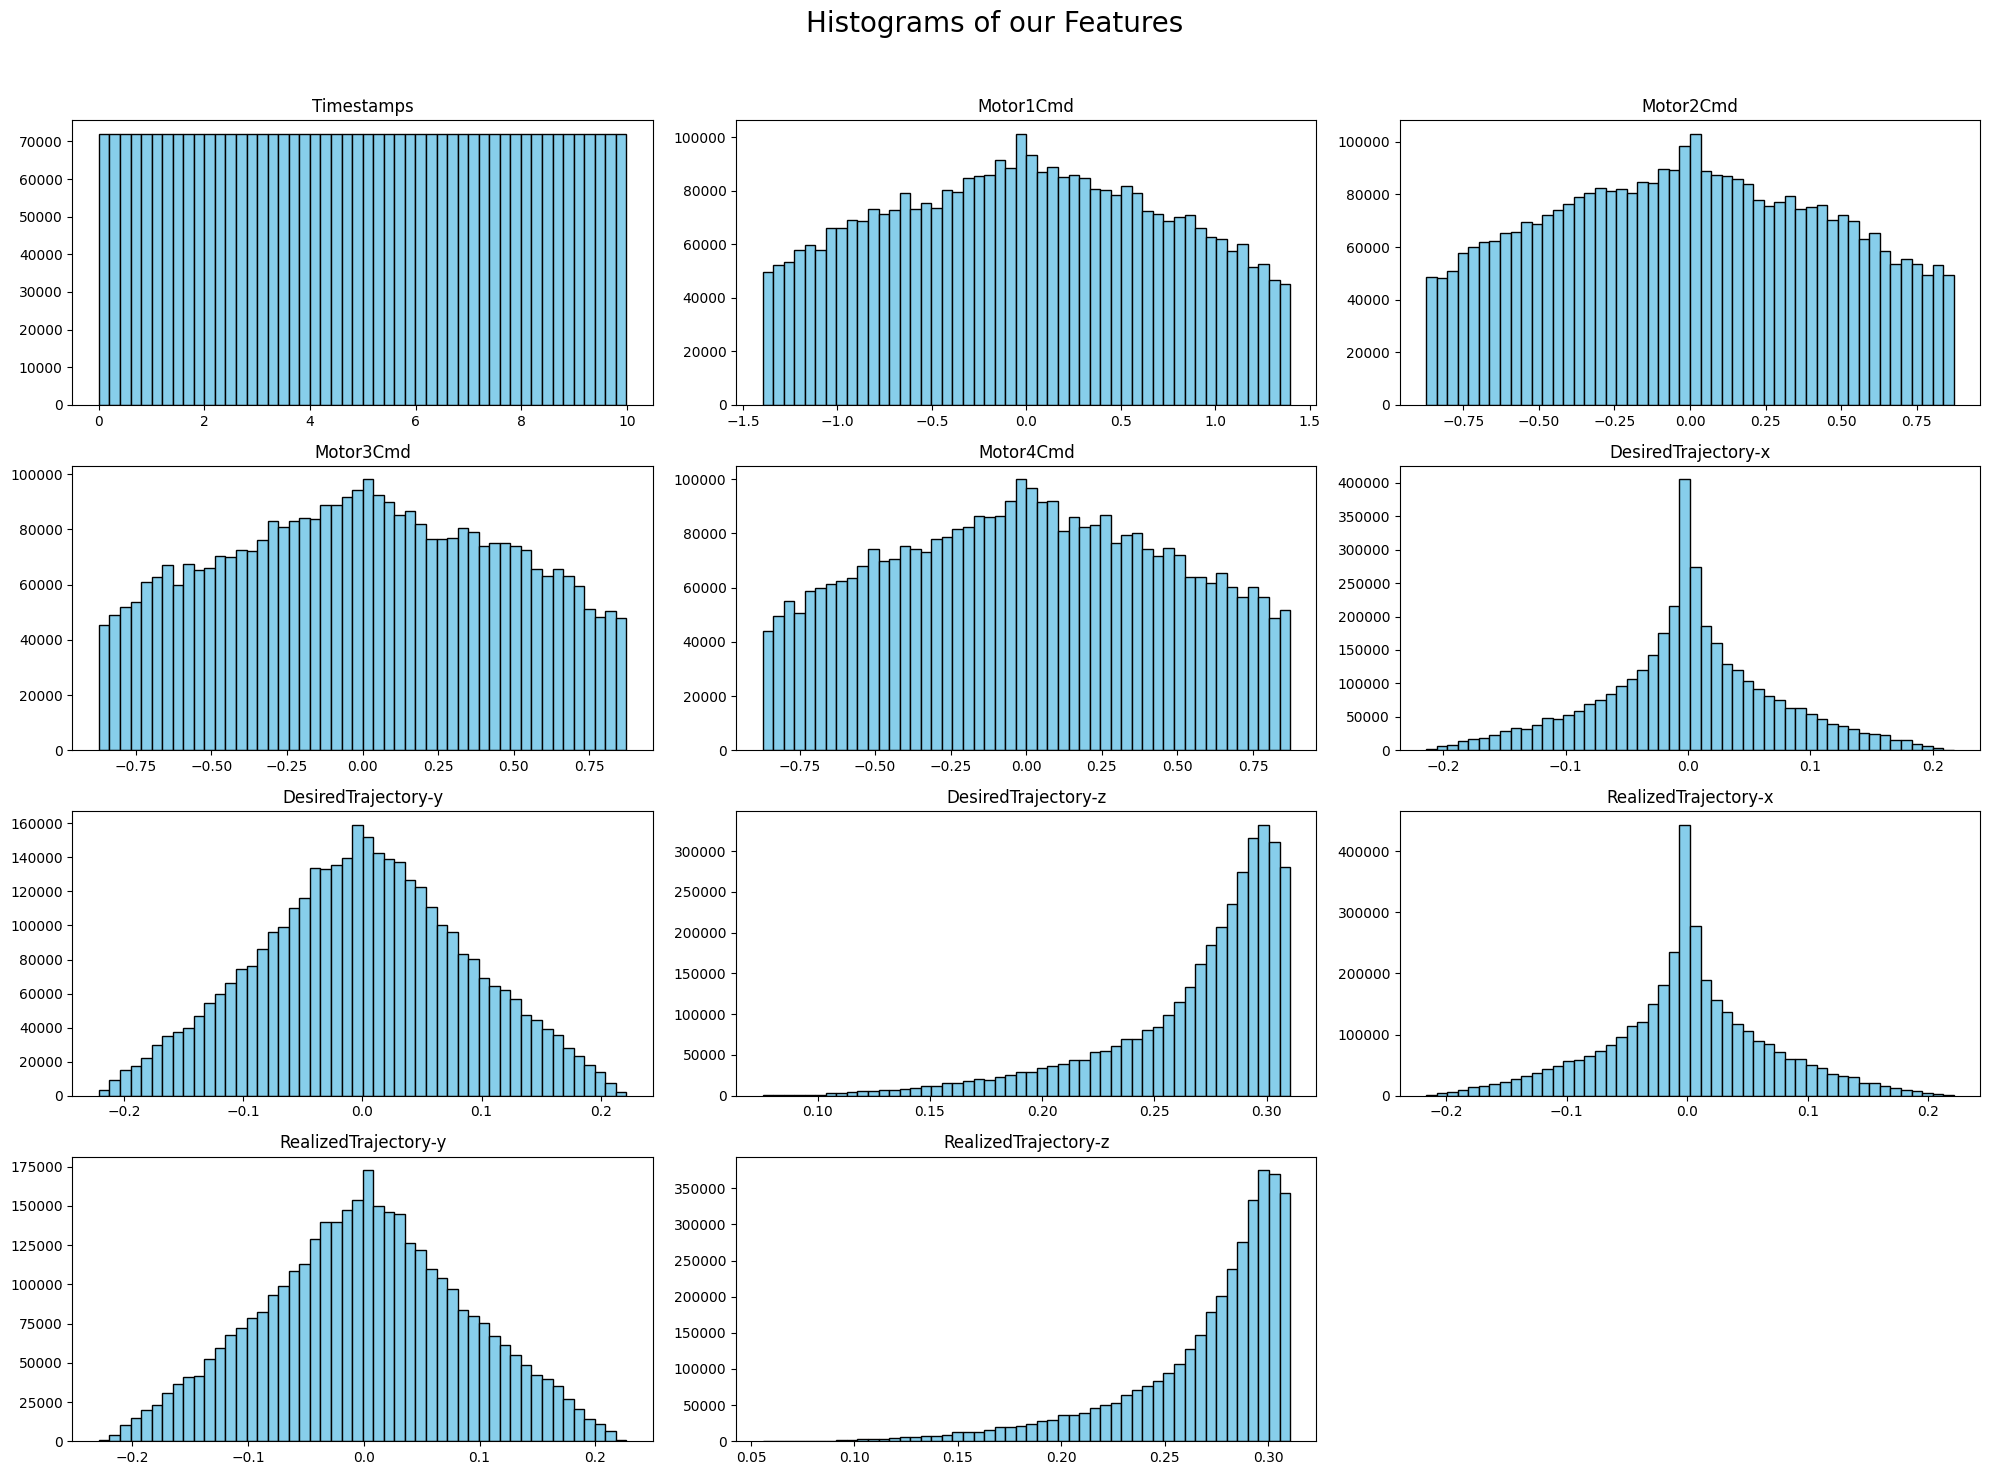

In [ ]:
data.hist(bins=50, figsize=(20, 15), edgecolor='black', grid=False, color='skyblue')
plt.suptitle('Histograms of our Features', fontsize=20) #without Motor5Cmd
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Show the plot
plt.show()

2025-02-23 19:20:52,648 - INFO - Using device: cpu
2025-02-23 19:21:47,906 - INFO - Epoch 1: Train Loss: 2.1867, Val Loss: 2.1545, Grad Norm: 0.2669
2025-02-23 19:21:47,909 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1867, Val Loss: 2.1545, Grad Norm: 0.2669


2025-02-23 19:22:33,496 - INFO - Epoch 2: Train Loss: 2.0472, Val Loss: 2.0069, Grad Norm: 2.2044
2025-02-23 19:22:33,497 - INFO - Best model saved.


Epoch 2: Train Loss: 2.0472, Val Loss: 2.0069, Grad Norm: 2.2044


2025-02-23 19:23:19,163 - INFO - Epoch 3: Train Loss: 1.9860, Val Loss: 1.9737, Grad Norm: 1.3101
2025-02-23 19:23:19,165 - INFO - Best model saved.


Epoch 3: Train Loss: 1.9860, Val Loss: 1.9737, Grad Norm: 1.3101


2025-02-23 19:24:04,989 - INFO - Epoch 4: Train Loss: 1.9070, Val Loss: 1.9531, Grad Norm: 3.1164
2025-02-23 19:24:04,991 - INFO - Best model saved.


Epoch 4: Train Loss: 1.9070, Val Loss: 1.9531, Grad Norm: 3.1164


2025-02-23 19:24:50,181 - INFO - Epoch 5: Train Loss: 1.8333, Val Loss: 1.7607, Grad Norm: 2.1991
2025-02-23 19:24:50,182 - INFO - Best model saved.


Epoch 5: Train Loss: 1.8333, Val Loss: 1.7607, Grad Norm: 2.1991


2025-02-23 19:25:36,875 - INFO - Epoch 6: Train Loss: 1.7451, Val Loss: 1.7550, Grad Norm: 2.9439
2025-02-23 19:25:36,878 - INFO - Best model saved.


Epoch 6: Train Loss: 1.7451, Val Loss: 1.7550, Grad Norm: 2.9439


2025-02-23 19:26:20,826 - INFO - Epoch 7: Train Loss: 1.6857, Val Loss: 1.6759, Grad Norm: 6.2013
2025-02-23 19:26:20,827 - INFO - Best model saved.


Epoch 7: Train Loss: 1.6857, Val Loss: 1.6759, Grad Norm: 6.2013


2025-02-23 19:27:06,473 - INFO - Epoch 8: Train Loss: 1.6323, Val Loss: 1.6306, Grad Norm: 5.1788
2025-02-23 19:27:06,475 - INFO - Best model saved.


Epoch 8: Train Loss: 1.6323, Val Loss: 1.6306, Grad Norm: 5.1788


2025-02-23 19:27:50,743 - INFO - Epoch 9: Train Loss: 1.5611, Val Loss: 1.4526, Grad Norm: 8.9628
2025-02-23 19:27:50,746 - INFO - Best model saved.


Epoch 9: Train Loss: 1.5611, Val Loss: 1.4526, Grad Norm: 8.9628


2025-02-23 19:28:34,983 - INFO - Epoch 10: Train Loss: 1.4550, Val Loss: 1.5042, Grad Norm: 7.5877


Epoch 10: Train Loss: 1.4550, Val Loss: 1.5042, Grad Norm: 7.5877


2025-02-23 19:29:20,872 - INFO - Epoch 11: Train Loss: 1.3914, Val Loss: 1.4261, Grad Norm: 7.6328
2025-02-23 19:29:20,875 - INFO - Best model saved.


Epoch 11: Train Loss: 1.3914, Val Loss: 1.4261, Grad Norm: 7.6328


2025-02-23 19:30:05,254 - INFO - Epoch 12: Train Loss: 1.3774, Val Loss: 1.5502, Grad Norm: 7.7081


Epoch 12: Train Loss: 1.3774, Val Loss: 1.5502, Grad Norm: 7.7081


2025-02-23 19:30:53,652 - INFO - Epoch 13: Train Loss: 1.3220, Val Loss: 1.4110, Grad Norm: 8.9678
2025-02-23 19:30:53,654 - INFO - Best model saved.


Epoch 13: Train Loss: 1.3220, Val Loss: 1.4110, Grad Norm: 8.9678


2025-02-23 19:31:42,992 - INFO - Epoch 14: Train Loss: 1.2975, Val Loss: 1.3360, Grad Norm: 12.0137
2025-02-23 19:31:42,994 - INFO - Best model saved.


Epoch 14: Train Loss: 1.2975, Val Loss: 1.3360, Grad Norm: 12.0137


2025-02-23 19:32:30,278 - INFO - Epoch 15: Train Loss: 1.2759, Val Loss: 1.2432, Grad Norm: 12.4572
2025-02-23 19:32:30,281 - INFO - Best model saved.


Epoch 15: Train Loss: 1.2759, Val Loss: 1.2432, Grad Norm: 12.4572


2025-02-23 19:33:16,944 - INFO - Epoch 16: Train Loss: 1.2629, Val Loss: 1.3476, Grad Norm: 9.1870


Epoch 16: Train Loss: 1.2629, Val Loss: 1.3476, Grad Norm: 9.1870


2025-02-23 19:34:03,769 - INFO - Epoch 17: Train Loss: 1.2425, Val Loss: 1.2916, Grad Norm: 9.7452


Epoch 17: Train Loss: 1.2425, Val Loss: 1.2916, Grad Norm: 9.7452


2025-02-23 19:34:51,666 - INFO - Epoch 18: Train Loss: 1.2094, Val Loss: 1.2277, Grad Norm: 9.6851
2025-02-23 19:34:51,668 - INFO - Best model saved.


Epoch 18: Train Loss: 1.2094, Val Loss: 1.2277, Grad Norm: 9.6851


2025-02-23 19:35:38,760 - INFO - Epoch 19: Train Loss: 1.1928, Val Loss: 1.3444, Grad Norm: 9.3296


Epoch 19: Train Loss: 1.1928, Val Loss: 1.3444, Grad Norm: 9.3296


2025-02-23 19:36:24,654 - INFO - Epoch 20: Train Loss: 1.1752, Val Loss: 1.2833, Grad Norm: 9.5892


Epoch 20: Train Loss: 1.1752, Val Loss: 1.2833, Grad Norm: 9.5892


2025-02-23 19:37:12,274 - INFO - Epoch 21: Train Loss: 1.1632, Val Loss: 1.1304, Grad Norm: 9.7032
2025-02-23 19:37:12,276 - INFO - Best model saved.


Epoch 21: Train Loss: 1.1632, Val Loss: 1.1304, Grad Norm: 9.7032


2025-02-23 19:38:00,819 - INFO - Epoch 22: Train Loss: 1.1271, Val Loss: 1.2074, Grad Norm: 13.0634


Epoch 22: Train Loss: 1.1271, Val Loss: 1.2074, Grad Norm: 13.0634


2025-02-23 19:38:49,448 - INFO - Epoch 23: Train Loss: 1.1365, Val Loss: 1.2193, Grad Norm: 8.9968


Epoch 23: Train Loss: 1.1365, Val Loss: 1.2193, Grad Norm: 8.9968


2025-02-23 19:39:38,007 - INFO - Epoch 24: Train Loss: 1.1099, Val Loss: 1.1631, Grad Norm: 9.5092


Epoch 24: Train Loss: 1.1099, Val Loss: 1.1631, Grad Norm: 9.5092


2025-02-23 19:40:27,892 - INFO - Epoch 25: Train Loss: 1.1212, Val Loss: 1.2614, Grad Norm: 10.7510


Epoch 25: Train Loss: 1.1212, Val Loss: 1.2614, Grad Norm: 10.7510


2025-02-23 19:41:18,605 - INFO - Epoch 26: Train Loss: 1.0972, Val Loss: 1.1280, Grad Norm: 9.6408
2025-02-23 19:41:18,608 - INFO - Best model saved.


Epoch 26: Train Loss: 1.0972, Val Loss: 1.1280, Grad Norm: 9.6408


2025-02-23 19:42:06,382 - INFO - Epoch 27: Train Loss: 1.0951, Val Loss: 1.1790, Grad Norm: 9.4245


Epoch 27: Train Loss: 1.0951, Val Loss: 1.1790, Grad Norm: 9.4245


2025-02-23 19:42:53,481 - INFO - Epoch 28: Train Loss: 1.0767, Val Loss: 1.1588, Grad Norm: 9.9454


Epoch 28: Train Loss: 1.0767, Val Loss: 1.1588, Grad Norm: 9.9454


2025-02-23 19:43:44,226 - INFO - Epoch 29: Train Loss: 1.0768, Val Loss: 1.1746, Grad Norm: 10.8983


Epoch 29: Train Loss: 1.0768, Val Loss: 1.1746, Grad Norm: 10.8983


2025-02-23 19:44:32,986 - INFO - Epoch 30: Train Loss: 1.0652, Val Loss: 1.1519, Grad Norm: 10.7770


Epoch 30: Train Loss: 1.0652, Val Loss: 1.1519, Grad Norm: 10.7770


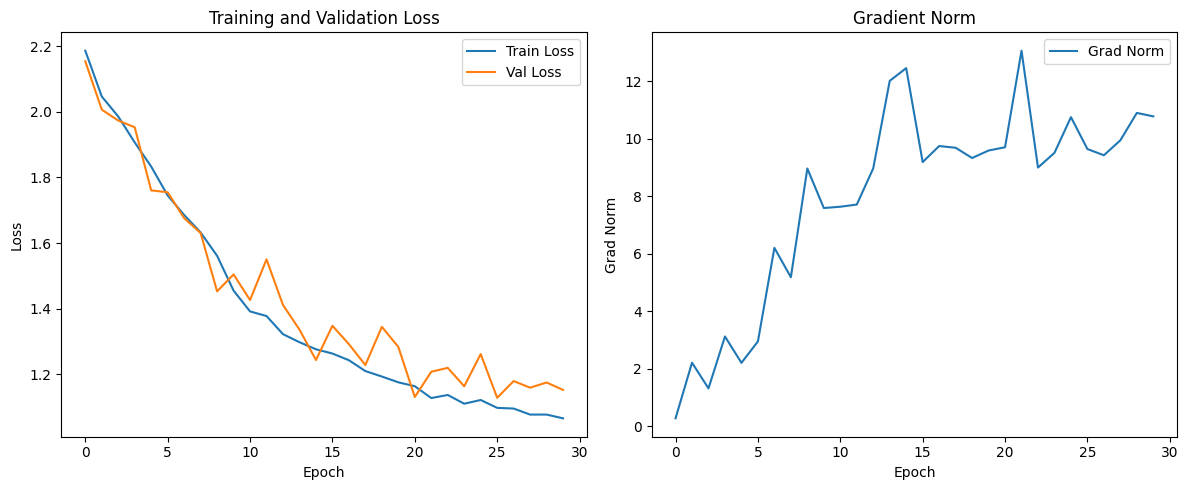

Accuracy: 0.5167
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.47      0.44        40
           1       0.71      0.75      0.73        40
           2       0.94      0.75      0.83        40
           3       0.30      0.30      0.30        40
           4       0.86      0.60      0.71        40
           5       0.31      0.38      0.34        40
           6       0.60      0.53      0.56        40
           7       0.39      0.55      0.45        40
           8       0.42      0.33      0.37        40

    accuracy                           0.52       360
   macro avg       0.55      0.52      0.53       360
weighted avg       0.55      0.52      0.53       360

F1 Score: 0.5255186167411805


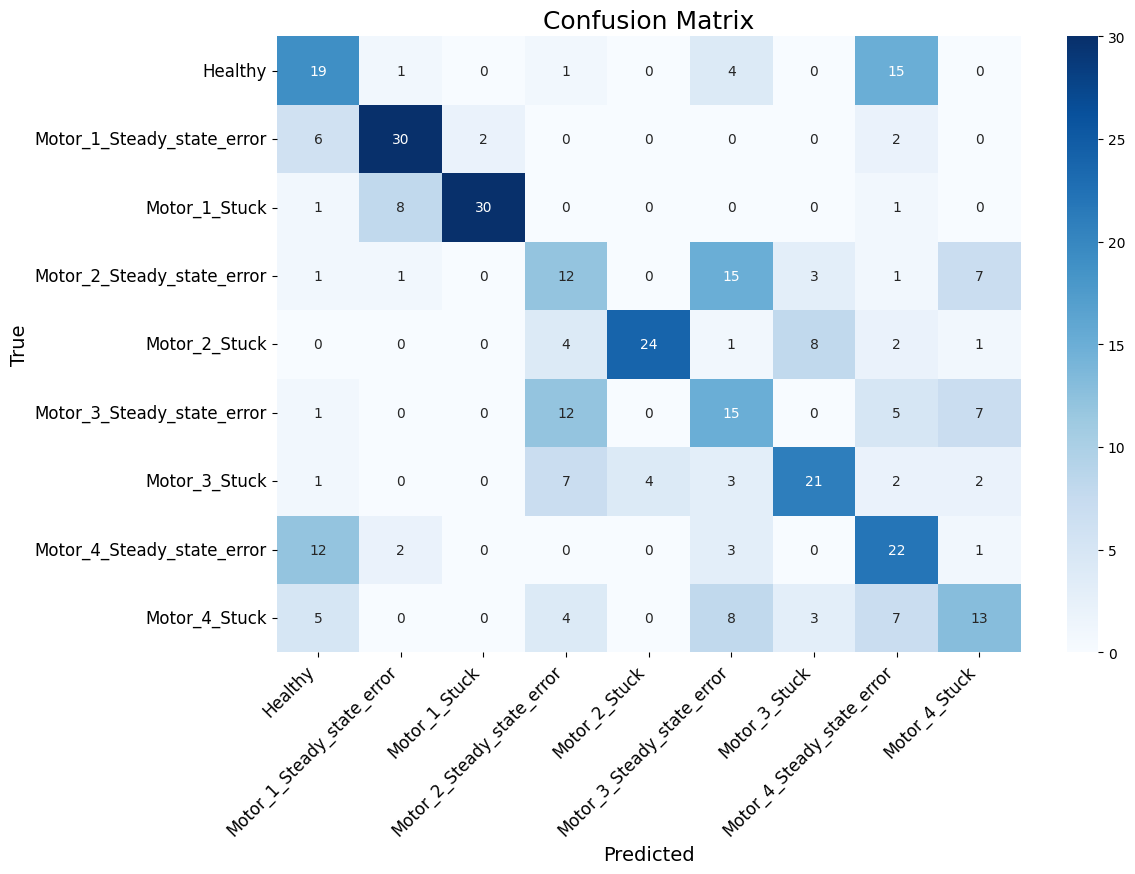

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Data starting point
df = data.copy()

# Check MPS/CUDA, but CPU for now even if GPU useful for batch handling but then have to handle to device CPU for LSTM...
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the LSTM model #
#########################
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 30
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

# Model training ###
#####################
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Train and Validation Loss
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['val_loss'], label='Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')

# Plot Gradient Norm
axs[1].plot(history['grad_norm'], label='Grad Norm')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Grad Norm')
axs[1].legend()
axs[1].set_title('Gradient Norm')

plt.tight_layout()
plt.show()


# Evaluate the model and obtain predictions (raw logits)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Use raw logits directly for ROC computation (ordering is preserved)
    y_pred_logits = y_pred.cpu().numpy()
    # Ground truth is one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print Weighted F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_64313/3947190263.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


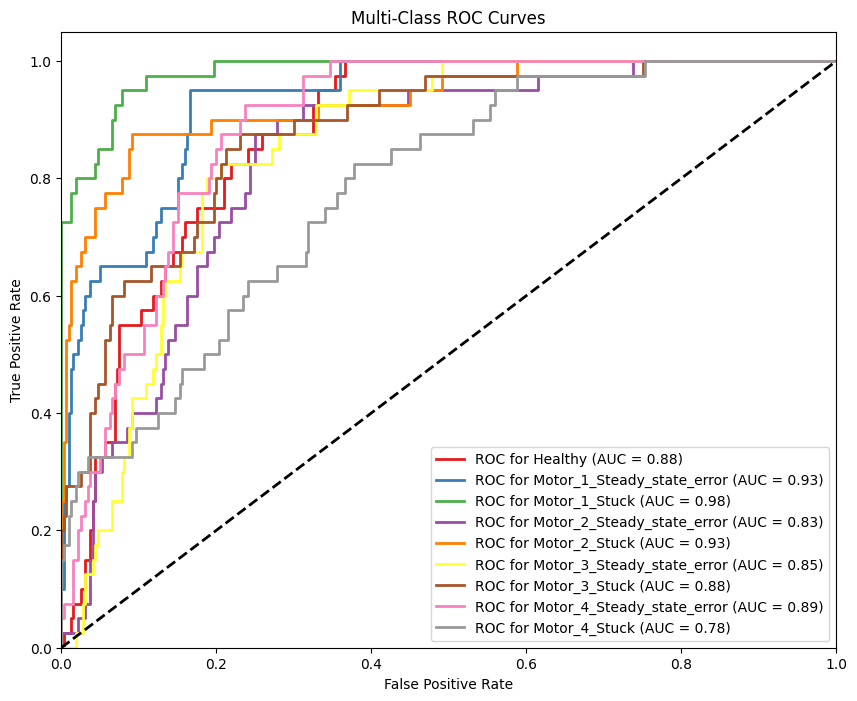

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.41      0.47      0.44        40
Motor_1_Steady_state_error       0.71      0.75      0.73        40
             Motor_1_Stuck       0.94      0.75      0.83        40
Motor_2_Steady_state_error       0.30      0.30      0.30        40
             Motor_2_Stuck       0.86      0.60      0.71        40
Motor_3_Steady_state_error       0.31      0.38      0.34        40
             Motor_3_Stuck       0.60      0.53      0.56        40
Motor_4_Steady_state_error       0.39      0.55      0.45        40
             Motor_4_Stuck       0.42      0.33      0.37        40

                  accuracy                           0.52       360
                 macro avg       0.55      0.52      0.53       360
              weighted avg       0.55      0.52      0.53       360



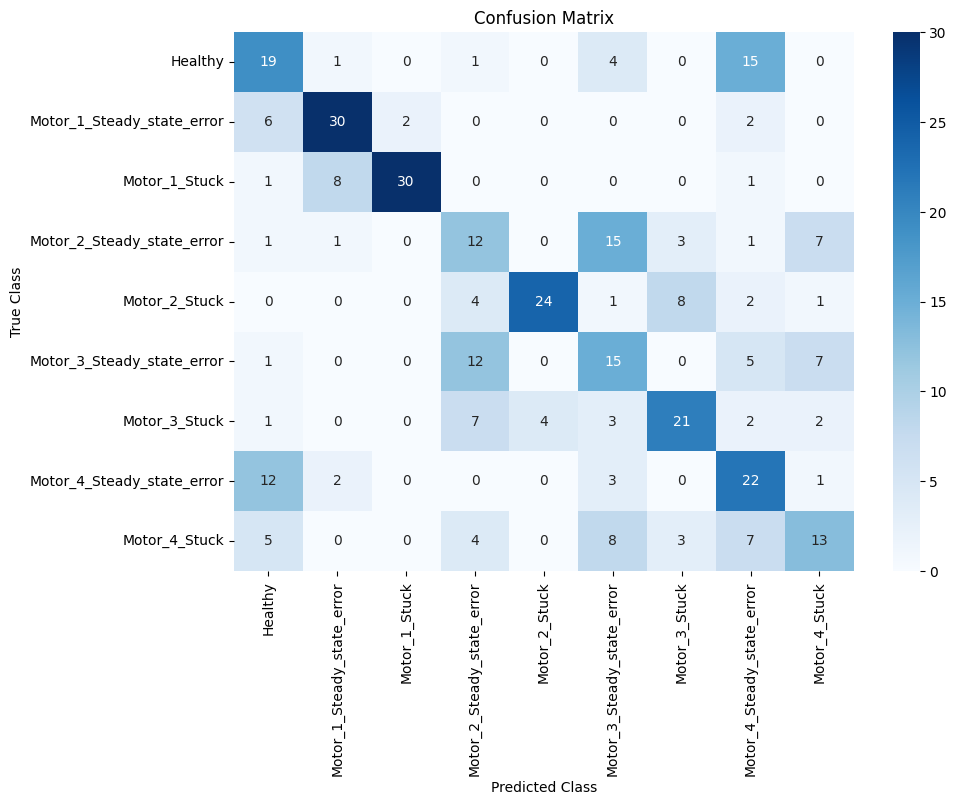

Weighted F1 Score: 0.5255186167411805


Another LSTM layer

2025-02-22 19:31:27,159 - INFO - Using device: cpu
2025-02-22 19:32:44,331 - INFO - Epoch 1: Train Loss: 2.1567, Val Loss: 2.0832, Grad Norm: 0.5382
2025-02-22 19:32:44,333 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1567, Val Loss: 2.0832, Grad Norm: 0.5382


2025-02-22 19:33:51,942 - INFO - Epoch 2: Train Loss: 1.9916, Val Loss: 1.9112, Grad Norm: 1.3401
2025-02-22 19:33:51,944 - INFO - Best model saved.


Epoch 2: Train Loss: 1.9916, Val Loss: 1.9112, Grad Norm: 1.3401


2025-02-22 19:34:59,939 - INFO - Epoch 3: Train Loss: 1.9313, Val Loss: 1.8504, Grad Norm: 1.1790
2025-02-22 19:34:59,941 - INFO - Best model saved.


Epoch 3: Train Loss: 1.9313, Val Loss: 1.8504, Grad Norm: 1.1790


2025-02-22 19:36:07,648 - INFO - Epoch 4: Train Loss: 1.8880, Val Loss: 1.8817, Grad Norm: 2.0602


Epoch 4: Train Loss: 1.8880, Val Loss: 1.8817, Grad Norm: 2.0602


2025-02-22 19:37:15,254 - INFO - Epoch 5: Train Loss: 1.8435, Val Loss: 1.8712, Grad Norm: 5.0452


Epoch 5: Train Loss: 1.8435, Val Loss: 1.8712, Grad Norm: 5.0452


2025-02-22 19:38:22,687 - INFO - Epoch 6: Train Loss: 1.8267, Val Loss: 1.8708, Grad Norm: 2.3198


Epoch 6: Train Loss: 1.8267, Val Loss: 1.8708, Grad Norm: 2.3198


2025-02-22 19:39:30,569 - INFO - Epoch 7: Train Loss: 1.8934, Val Loss: 1.8569, Grad Norm: 3.9693


Epoch 7: Train Loss: 1.8934, Val Loss: 1.8569, Grad Norm: 3.9693


2025-02-22 19:40:39,624 - INFO - Epoch 8: Train Loss: 1.8025, Val Loss: 1.7225, Grad Norm: 2.5353
2025-02-22 19:40:39,626 - INFO - Best model saved.


Epoch 8: Train Loss: 1.8025, Val Loss: 1.7225, Grad Norm: 2.5353


2025-02-22 19:41:48,137 - INFO - Epoch 9: Train Loss: 1.6959, Val Loss: 1.6082, Grad Norm: 4.3663
2025-02-22 19:41:48,138 - INFO - Best model saved.


Epoch 9: Train Loss: 1.6959, Val Loss: 1.6082, Grad Norm: 4.3663


2025-02-22 19:42:56,923 - INFO - Epoch 10: Train Loss: 1.5838, Val Loss: 1.5278, Grad Norm: 5.3234
2025-02-22 19:42:56,926 - INFO - Best model saved.


Epoch 10: Train Loss: 1.5838, Val Loss: 1.5278, Grad Norm: 5.3234


2025-02-22 19:44:05,983 - INFO - Epoch 11: Train Loss: 1.4985, Val Loss: 1.3916, Grad Norm: 6.5627
2025-02-22 19:44:05,985 - INFO - Best model saved.


Epoch 11: Train Loss: 1.4985, Val Loss: 1.3916, Grad Norm: 6.5627


2025-02-22 19:45:14,518 - INFO - Epoch 12: Train Loss: 1.4170, Val Loss: 1.3344, Grad Norm: 6.2873
2025-02-22 19:45:14,520 - INFO - Best model saved.


Epoch 12: Train Loss: 1.4170, Val Loss: 1.3344, Grad Norm: 6.2873


2025-02-22 19:46:23,010 - INFO - Epoch 13: Train Loss: 1.3684, Val Loss: 1.2894, Grad Norm: 8.6059
2025-02-22 19:46:23,012 - INFO - Best model saved.


Epoch 13: Train Loss: 1.3684, Val Loss: 1.2894, Grad Norm: 8.6059


2025-02-22 19:47:31,976 - INFO - Epoch 14: Train Loss: 1.2796, Val Loss: 1.2803, Grad Norm: 8.3313
2025-02-22 19:47:31,977 - INFO - Best model saved.


Epoch 14: Train Loss: 1.2796, Val Loss: 1.2803, Grad Norm: 8.3313


2025-02-22 19:48:40,188 - INFO - Epoch 15: Train Loss: 1.2418, Val Loss: 1.2158, Grad Norm: 9.6056
2025-02-22 19:48:40,189 - INFO - Best model saved.


Epoch 15: Train Loss: 1.2418, Val Loss: 1.2158, Grad Norm: 9.6056


2025-02-22 19:49:48,985 - INFO - Epoch 16: Train Loss: 1.2331, Val Loss: 1.2178, Grad Norm: 10.7983


Epoch 16: Train Loss: 1.2331, Val Loss: 1.2178, Grad Norm: 10.7983


2025-02-22 19:50:57,272 - INFO - Epoch 17: Train Loss: 1.2221, Val Loss: 1.2171, Grad Norm: 8.9075


Epoch 17: Train Loss: 1.2221, Val Loss: 1.2171, Grad Norm: 8.9075


2025-02-22 19:52:03,717 - INFO - Epoch 18: Train Loss: 1.1942, Val Loss: 1.2078, Grad Norm: 9.1243
2025-02-22 19:52:03,721 - INFO - Best model saved.


Epoch 18: Train Loss: 1.1942, Val Loss: 1.2078, Grad Norm: 9.1243


2025-02-22 19:53:10,896 - INFO - Epoch 19: Train Loss: 1.2273, Val Loss: 1.1815, Grad Norm: 9.2417
2025-02-22 19:53:10,899 - INFO - Best model saved.


Epoch 19: Train Loss: 1.2273, Val Loss: 1.1815, Grad Norm: 9.2417


2025-02-22 19:54:19,237 - INFO - Epoch 20: Train Loss: 1.1593, Val Loss: 1.1234, Grad Norm: 11.1500
2025-02-22 19:54:19,239 - INFO - Best model saved.


Epoch 20: Train Loss: 1.1593, Val Loss: 1.1234, Grad Norm: 11.1500


2025-02-22 19:55:25,756 - INFO - Epoch 21: Train Loss: 1.1643, Val Loss: 1.2601, Grad Norm: 10.0557


Epoch 21: Train Loss: 1.1643, Val Loss: 1.2601, Grad Norm: 10.0557


2025-02-22 19:56:33,733 - INFO - Epoch 22: Train Loss: 1.1478, Val Loss: 1.1941, Grad Norm: 9.9852


Epoch 22: Train Loss: 1.1478, Val Loss: 1.1941, Grad Norm: 9.9852


2025-02-22 19:57:42,696 - INFO - Epoch 23: Train Loss: 1.1461, Val Loss: 1.3039, Grad Norm: 10.2938


Epoch 23: Train Loss: 1.1461, Val Loss: 1.3039, Grad Norm: 10.2938


2025-02-22 19:58:51,362 - INFO - Epoch 24: Train Loss: 1.1337, Val Loss: 1.2161, Grad Norm: 9.8267


Epoch 24: Train Loss: 1.1337, Val Loss: 1.2161, Grad Norm: 9.8267


2025-02-22 20:00:00,537 - INFO - Epoch 25: Train Loss: 1.1252, Val Loss: 1.1422, Grad Norm: 11.2789
2025-02-22 20:00:00,538 - INFO - Early stopping triggered.


Epoch 25: Train Loss: 1.1252, Val Loss: 1.1422, Grad Norm: 11.2789


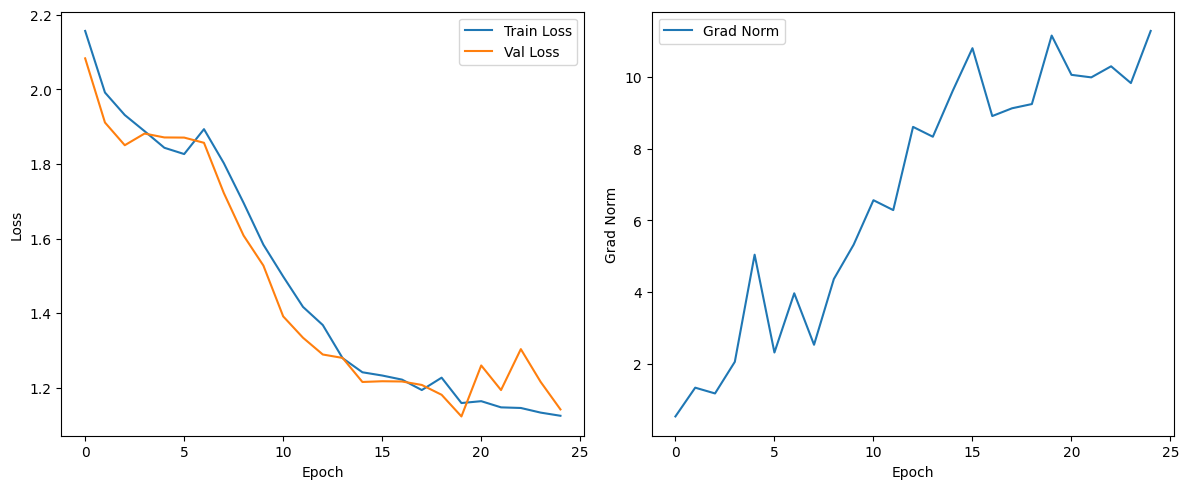

Accuracy: 0.5306
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.57      0.51        40
           1       0.61      0.68      0.64        40
           2       0.92      0.82      0.87        40
           3       0.50      0.30      0.38        40
           4       0.91      0.50      0.65        40
           5       0.42      0.60      0.49        40
           6       0.47      0.68      0.56        40
           7       0.35      0.42      0.38        40
           8       0.40      0.20      0.27        40

    accuracy                           0.53       360
   macro avg       0.56      0.53      0.53       360
weighted avg       0.56      0.53      0.53       360

Confusion Matrix:
 [[23  4  0  0  0  0  0 13  0]
 [ 8 27  3  0  0  1  0  1  0]
 [ 1  6 33  0  0  0  0  0  0]
 [ 0  0  0 12  0 11  8  3  6]
 [ 0  0  0  0 20  0 18  2  0]
 [ 0  2  0  5  0 24  0  4  5]
 [ 2  0  0  3  2  5 27  0  1]
 [14  4  0  0  0  5  0 17

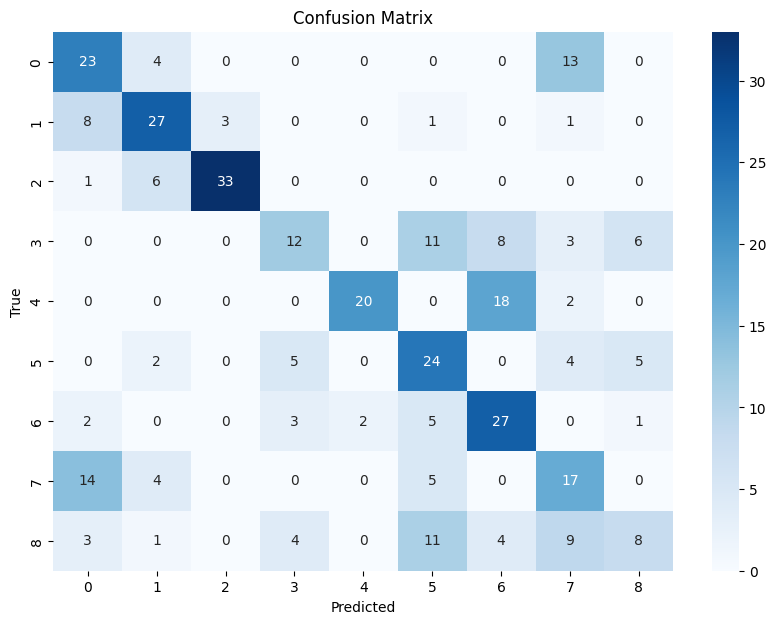

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1) not needed as CrossEntropyLoss includes softmax in the loss calculation

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x) not needed as CrossEntropyLoss includes softmax in the loss calculation

        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 30
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model and obtain predictions (raw logits)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Use raw logits directly for ROC computation (ordering is preserved)
    y_pred_logits = y_pred.cpu().numpy()
    # Ground truth is one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print Weighted F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


# With 20% split

2025-02-22 22:48:32,565 - INFO - Using device: cpu
2025-02-22 22:49:46,601 - INFO - Epoch 1: Train Loss: 2.1900, Val Loss: 2.1311, Grad Norm: 0.2466
2025-02-22 22:49:46,606 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1900, Val Loss: 2.1311, Grad Norm: 0.2466


2025-02-22 22:50:47,479 - INFO - Epoch 2: Train Loss: 2.0909, Val Loss: 2.0614, Grad Norm: 1.1169
2025-02-22 22:50:47,481 - INFO - Best model saved.


Epoch 2: Train Loss: 2.0909, Val Loss: 2.0614, Grad Norm: 1.1169


2025-02-22 22:51:47,725 - INFO - Epoch 3: Train Loss: 2.0119, Val Loss: 1.9296, Grad Norm: 2.1868
2025-02-22 22:51:47,729 - INFO - Best model saved.


Epoch 3: Train Loss: 2.0119, Val Loss: 1.9296, Grad Norm: 2.1868


2025-02-22 22:52:46,081 - INFO - Epoch 4: Train Loss: 1.8883, Val Loss: 1.7380, Grad Norm: 2.2261
2025-02-22 22:52:46,083 - INFO - Best model saved.


Epoch 4: Train Loss: 1.8883, Val Loss: 1.7380, Grad Norm: 2.2261


2025-02-22 22:53:45,370 - INFO - Epoch 5: Train Loss: 1.7294, Val Loss: 1.6680, Grad Norm: 3.8364
2025-02-22 22:53:45,373 - INFO - Best model saved.


Epoch 5: Train Loss: 1.7294, Val Loss: 1.6680, Grad Norm: 3.8364


2025-02-22 22:54:44,524 - INFO - Epoch 6: Train Loss: 1.6096, Val Loss: 1.5666, Grad Norm: 5.7509
2025-02-22 22:54:44,527 - INFO - Best model saved.


Epoch 6: Train Loss: 1.6096, Val Loss: 1.5666, Grad Norm: 5.7509


2025-02-22 22:55:42,299 - INFO - Epoch 7: Train Loss: 1.5468, Val Loss: 1.4466, Grad Norm: 6.3499
2025-02-22 22:55:42,301 - INFO - Best model saved.


Epoch 7: Train Loss: 1.5468, Val Loss: 1.4466, Grad Norm: 6.3499


2025-02-22 22:56:39,620 - INFO - Epoch 8: Train Loss: 1.4640, Val Loss: 1.3844, Grad Norm: 5.9838
2025-02-22 22:56:39,621 - INFO - Best model saved.


Epoch 8: Train Loss: 1.4640, Val Loss: 1.3844, Grad Norm: 5.9838


2025-02-22 22:57:37,659 - INFO - Epoch 9: Train Loss: 1.3875, Val Loss: 1.3706, Grad Norm: 6.7741
2025-02-22 22:57:37,662 - INFO - Best model saved.


Epoch 9: Train Loss: 1.3875, Val Loss: 1.3706, Grad Norm: 6.7741


2025-02-22 22:58:36,898 - INFO - Epoch 10: Train Loss: 1.3500, Val Loss: 1.3361, Grad Norm: 10.0253
2025-02-22 22:58:36,907 - INFO - Best model saved.


Epoch 10: Train Loss: 1.3500, Val Loss: 1.3361, Grad Norm: 10.0253


2025-02-22 22:59:34,538 - INFO - Epoch 11: Train Loss: 1.3055, Val Loss: 1.3006, Grad Norm: 8.6103
2025-02-22 22:59:34,542 - INFO - Best model saved.


Epoch 11: Train Loss: 1.3055, Val Loss: 1.3006, Grad Norm: 8.6103


2025-02-22 23:00:31,955 - INFO - Epoch 12: Train Loss: 1.2865, Val Loss: 1.2352, Grad Norm: 11.1360
2025-02-22 23:00:31,959 - INFO - Best model saved.


Epoch 12: Train Loss: 1.2865, Val Loss: 1.2352, Grad Norm: 11.1360


2025-02-22 23:01:29,317 - INFO - Epoch 13: Train Loss: 1.2752, Val Loss: 1.2427, Grad Norm: 9.5345


Epoch 13: Train Loss: 1.2752, Val Loss: 1.2427, Grad Norm: 9.5345


2025-02-22 23:02:28,046 - INFO - Epoch 14: Train Loss: 1.2350, Val Loss: 1.2679, Grad Norm: 8.8568


Epoch 14: Train Loss: 1.2350, Val Loss: 1.2679, Grad Norm: 8.8568


2025-02-22 23:03:27,165 - INFO - Epoch 15: Train Loss: 1.2166, Val Loss: 1.2155, Grad Norm: 10.1819
2025-02-22 23:03:27,170 - INFO - Best model saved.


Epoch 15: Train Loss: 1.2166, Val Loss: 1.2155, Grad Norm: 10.1819


2025-02-22 23:04:25,260 - INFO - Epoch 16: Train Loss: 1.1880, Val Loss: 1.1950, Grad Norm: 9.4516
2025-02-22 23:04:25,263 - INFO - Best model saved.


Epoch 16: Train Loss: 1.1880, Val Loss: 1.1950, Grad Norm: 9.4516


2025-02-22 23:05:23,803 - INFO - Epoch 17: Train Loss: 1.1747, Val Loss: 1.2888, Grad Norm: 10.9065


Epoch 17: Train Loss: 1.1747, Val Loss: 1.2888, Grad Norm: 10.9065


2025-02-22 23:06:22,316 - INFO - Epoch 18: Train Loss: 1.1738, Val Loss: 1.1942, Grad Norm: 9.8945
2025-02-22 23:06:22,320 - INFO - Best model saved.


Epoch 18: Train Loss: 1.1738, Val Loss: 1.1942, Grad Norm: 9.8945


2025-02-22 23:07:20,502 - INFO - Epoch 19: Train Loss: 1.1686, Val Loss: 1.2170, Grad Norm: 10.7613


Epoch 19: Train Loss: 1.1686, Val Loss: 1.2170, Grad Norm: 10.7613


2025-02-22 23:08:18,558 - INFO - Epoch 20: Train Loss: 1.1593, Val Loss: 1.1529, Grad Norm: 10.7455
2025-02-22 23:08:18,561 - INFO - Best model saved.


Epoch 20: Train Loss: 1.1593, Val Loss: 1.1529, Grad Norm: 10.7455


2025-02-22 23:09:16,965 - INFO - Epoch 21: Train Loss: 1.1594, Val Loss: 1.1681, Grad Norm: 9.0576


Epoch 21: Train Loss: 1.1594, Val Loss: 1.1681, Grad Norm: 9.0576


2025-02-22 23:10:14,921 - INFO - Epoch 22: Train Loss: 1.1333, Val Loss: 1.1155, Grad Norm: 11.1369
2025-02-22 23:10:14,925 - INFO - Best model saved.


Epoch 22: Train Loss: 1.1333, Val Loss: 1.1155, Grad Norm: 11.1369


2025-02-22 23:11:13,123 - INFO - Epoch 23: Train Loss: 1.1048, Val Loss: 1.2180, Grad Norm: 11.1661


Epoch 23: Train Loss: 1.1048, Val Loss: 1.2180, Grad Norm: 11.1661


2025-02-22 23:12:11,237 - INFO - Epoch 24: Train Loss: 1.1265, Val Loss: 1.1436, Grad Norm: 12.2385


Epoch 24: Train Loss: 1.1265, Val Loss: 1.1436, Grad Norm: 12.2385


2025-02-22 23:13:10,040 - INFO - Epoch 25: Train Loss: 1.1033, Val Loss: 1.1991, Grad Norm: 10.0338


Epoch 25: Train Loss: 1.1033, Val Loss: 1.1991, Grad Norm: 10.0338


2025-02-22 23:14:08,723 - INFO - Epoch 26: Train Loss: 1.0823, Val Loss: 1.1314, Grad Norm: 10.9314


Epoch 26: Train Loss: 1.0823, Val Loss: 1.1314, Grad Norm: 10.9314


2025-02-22 23:15:08,231 - INFO - Epoch 27: Train Loss: 1.1064, Val Loss: 1.1635, Grad Norm: 10.1309
2025-02-22 23:15:08,232 - INFO - Early stopping triggered.


Epoch 27: Train Loss: 1.1064, Val Loss: 1.1635, Grad Norm: 10.1309


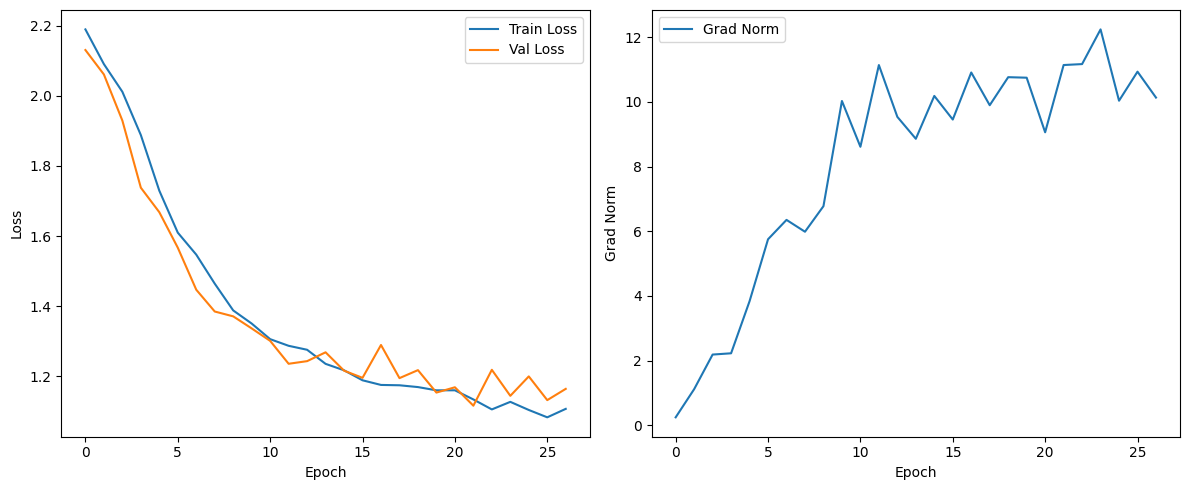

Accuracy: 0.5361
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.76      0.58        80
           1       0.74      0.62      0.68        80
           2       0.88      0.82      0.85        80
           3       0.56      0.25      0.34        80
           4       0.67      0.50      0.57        80
           5       0.40      0.39      0.39        80
           6       0.55      0.46      0.50        80
           7       0.44      0.53      0.48        80
           8       0.35      0.49      0.41        80

    accuracy                           0.54       720
   macro avg       0.56      0.54      0.53       720
weighted avg       0.56      0.54      0.53       720

Confusion Matrix:
 [[61  5  0  0  0  0  0 14  0]
 [18 50  8  0  0  0  0  4  0]
 [ 5  9 66  0  0  0  0  0  0]
 [ 2  2  0 20  1 12  8  7 28]
 [ 4  0  0  4 40  6 17  2  7]
 [ 2  0  0  5  0 31  0 15 27]
 [ 0  0  0  4 19  6 37  4 10]
 [27  2  0  0  0  8  0 42

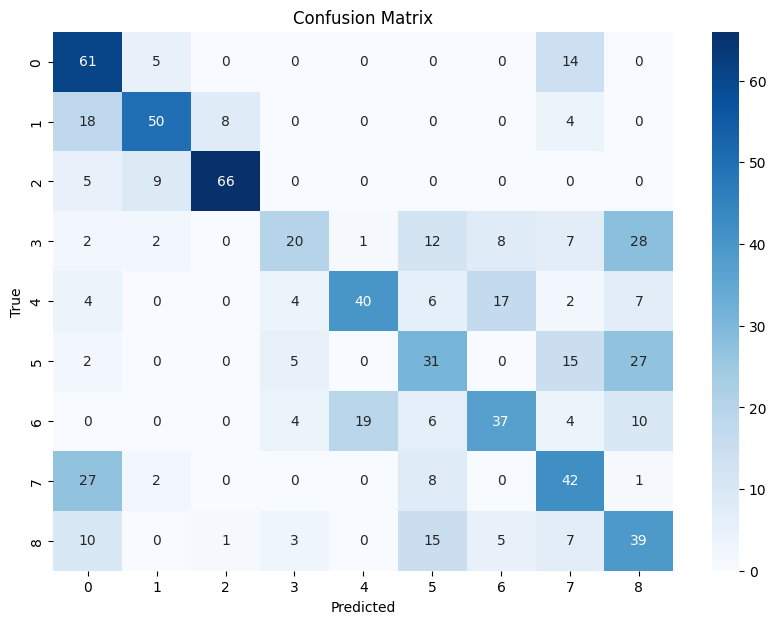

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1), not using softmax as CrossEntropyLoss already applies it

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x)
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 50
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model and obtain predictions (raw logits)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Use raw logits directly for ROC computation (ordering is preserved)
    y_pred_logits = y_pred.cpu().numpy()
    # Ground truth is one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print Weighted F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


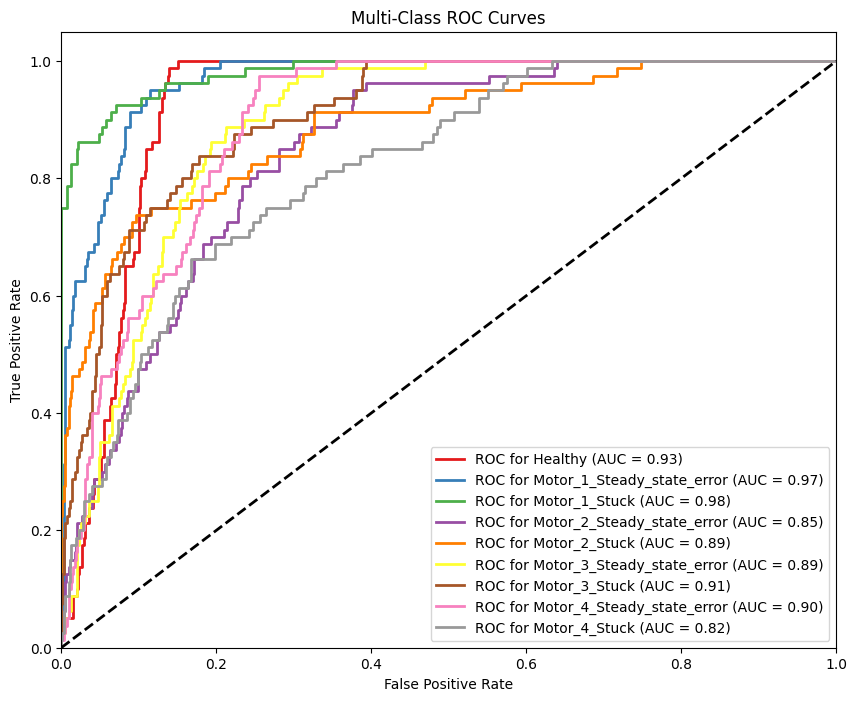

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.47      0.76      0.58        80
Motor_1_Steady_state_error       0.74      0.62      0.68        80
             Motor_1_Stuck       0.88      0.82      0.85        80
Motor_2_Steady_state_error       0.56      0.25      0.34        80
             Motor_2_Stuck       0.67      0.50      0.57        80
Motor_3_Steady_state_error       0.40      0.39      0.39        80
             Motor_3_Stuck       0.55      0.46      0.50        80
Motor_4_Steady_state_error       0.44      0.53      0.48        80
             Motor_4_Stuck       0.35      0.49      0.41        80

                  accuracy                           0.54       720
                 macro avg       0.56      0.54      0.53       720
              weighted avg       0.56      0.54      0.53       720



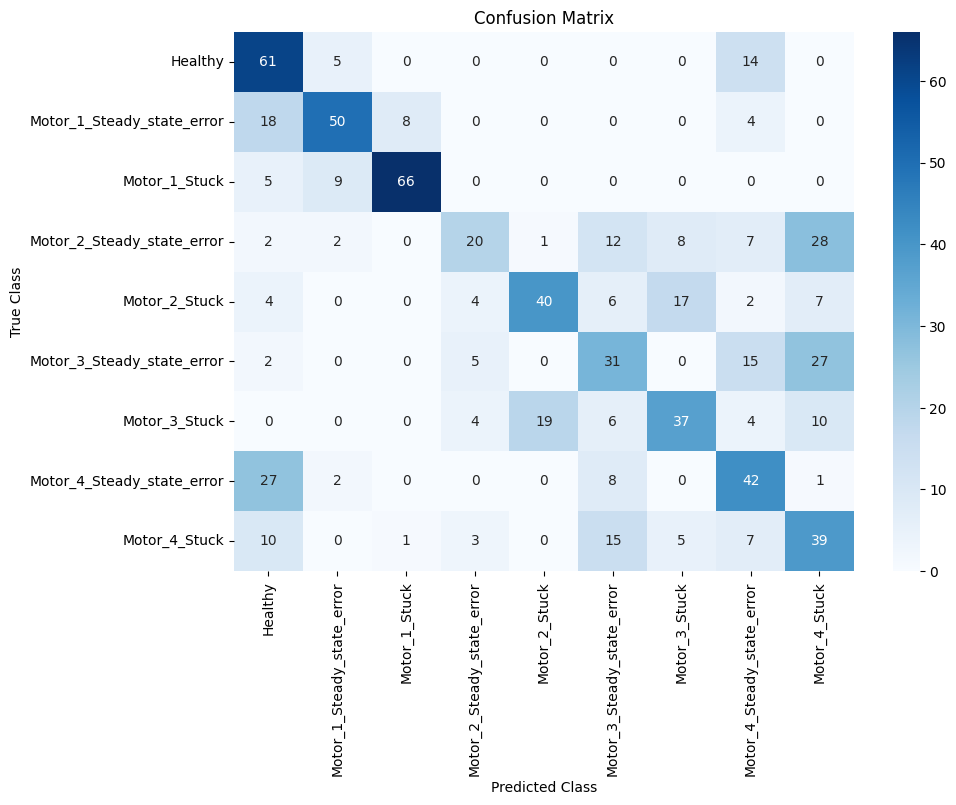

Weighted F1 Score: 0.5343703575320639


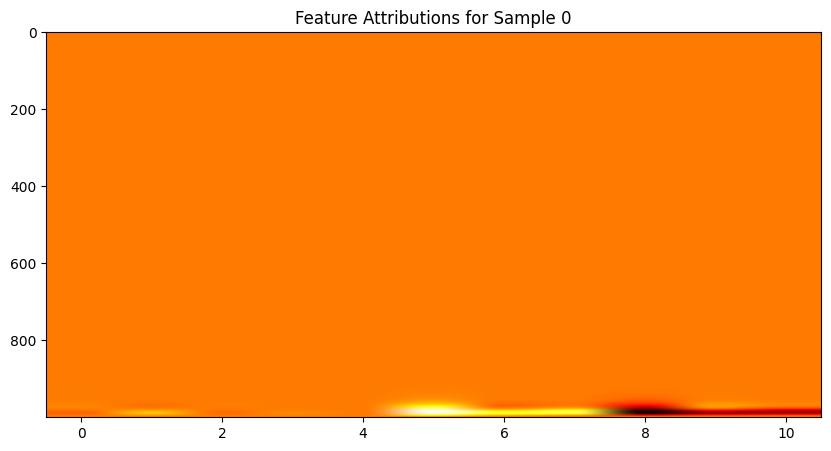

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
import seaborn as sns

# Evaluate the model and obtain probability predictions using softmax
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Apply softmax to get probabilities for each class
    y_pred_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
    # Ground truth is already one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n",
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print F1 Score (weighted)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)




# Vanilla BiLSTM 200 hidden dim

2025-02-23 20:31:36,649 - INFO - Using device: cpu
2025-02-23 20:33:22,273 - INFO - Epoch 1: Train Loss: 2.1792, Val Loss: 2.1004, Grad Norm: 0.8251
2025-02-23 20:33:22,277 - INFO - Best model saved.


Epoch 1: Train Loss: 2.1792, Val Loss: 2.1004, Grad Norm: 0.8251


2025-02-23 20:34:56,777 - INFO - Epoch 2: Train Loss: 2.0610, Val Loss: 2.1157, Grad Norm: 1.7331


Epoch 2: Train Loss: 2.0610, Val Loss: 2.1157, Grad Norm: 1.7331


2025-02-23 20:36:32,887 - INFO - Epoch 3: Train Loss: 1.9803, Val Loss: 1.9022, Grad Norm: 2.3365
2025-02-23 20:36:32,890 - INFO - Best model saved.


Epoch 3: Train Loss: 1.9803, Val Loss: 1.9022, Grad Norm: 2.3365


2025-02-23 20:38:08,132 - INFO - Epoch 4: Train Loss: 1.9763, Val Loss: 1.7722, Grad Norm: 18.3105
2025-02-23 20:38:08,135 - INFO - Best model saved.


Epoch 4: Train Loss: 1.9763, Val Loss: 1.7722, Grad Norm: 18.3105


2025-02-23 20:39:42,868 - INFO - Epoch 5: Train Loss: 1.6742, Val Loss: 1.7333, Grad Norm: 3.8745
2025-02-23 20:39:42,871 - INFO - Best model saved.


Epoch 5: Train Loss: 1.6742, Val Loss: 1.7333, Grad Norm: 3.8745


2025-02-23 20:41:19,863 - INFO - Epoch 6: Train Loss: 1.8735, Val Loss: 1.9307, Grad Norm: 2.5664


Epoch 6: Train Loss: 1.8735, Val Loss: 1.9307, Grad Norm: 2.5664


2025-02-23 20:42:54,012 - INFO - Epoch 7: Train Loss: 1.8516, Val Loss: 1.6937, Grad Norm: 5.0442
2025-02-23 20:42:54,015 - INFO - Best model saved.


Epoch 7: Train Loss: 1.8516, Val Loss: 1.6937, Grad Norm: 5.0442


2025-02-23 20:44:30,493 - INFO - Epoch 8: Train Loss: 1.8626, Val Loss: 3.0139, Grad Norm: 18.9416


Epoch 8: Train Loss: 1.8626, Val Loss: 3.0139, Grad Norm: 18.9416


2025-02-23 20:46:03,977 - INFO - Epoch 9: Train Loss: 2.3136, Val Loss: 2.1578, Grad Norm: 6.1881


Epoch 9: Train Loss: 2.3136, Val Loss: 2.1578, Grad Norm: 6.1881


2025-02-23 20:47:39,342 - INFO - Epoch 10: Train Loss: 2.1467, Val Loss: 2.1359, Grad Norm: 0.5422


Epoch 10: Train Loss: 2.1467, Val Loss: 2.1359, Grad Norm: 0.5422


2025-02-23 20:49:14,210 - INFO - Epoch 11: Train Loss: 2.1337, Val Loss: 2.1349, Grad Norm: 0.2488


Epoch 11: Train Loss: 2.1337, Val Loss: 2.1349, Grad Norm: 0.2488


2025-02-23 20:50:49,298 - INFO - Epoch 12: Train Loss: 2.1327, Val Loss: 2.1351, Grad Norm: 0.2543
2025-02-23 20:50:49,298 - INFO - Early stopping triggered.


Epoch 12: Train Loss: 2.1327, Val Loss: 2.1351, Grad Norm: 0.2543


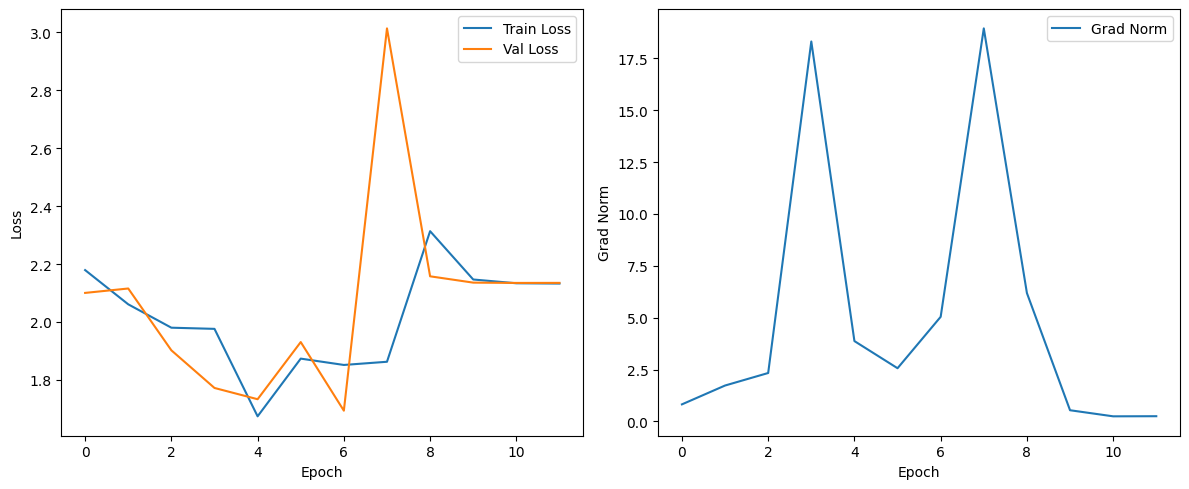

/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_64313/3953445825.py:204: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


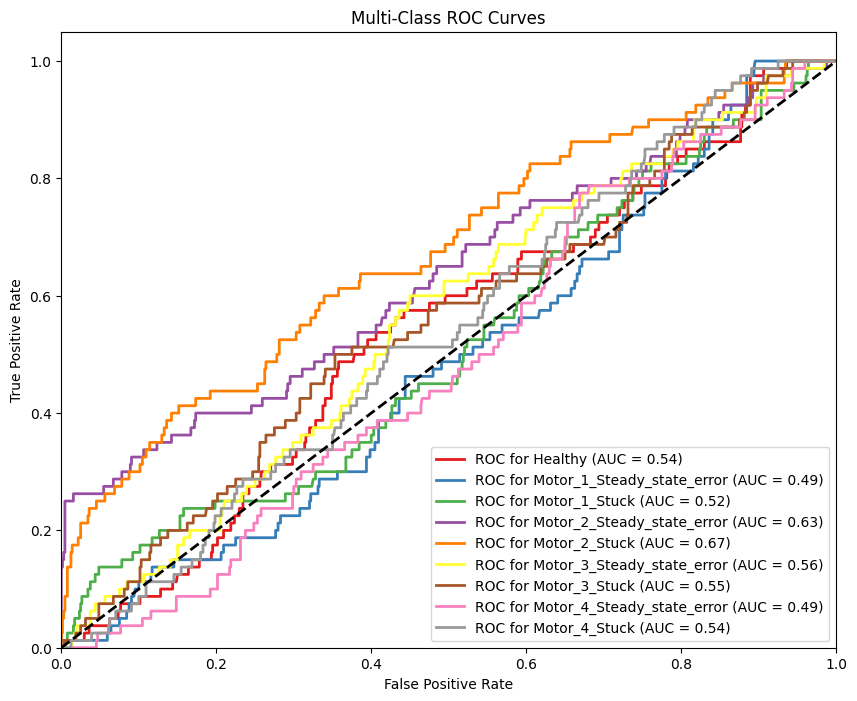

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.00      0.00      0.00        80
Motor_1_Steady_state_error       0.11      1.00      0.21        80
             Motor_1_Stuck       0.00      0.00      0.00        80
Motor_2_Steady_state_error       0.87      0.25      0.39        80
             Motor_2_Stuck       0.00      0.00      0.00        80
Motor_3_Steady_state_error       0.00      0.00      0.00        80
             Motor_3_Stuck       0.00      0.00      0.00        80
Motor_4_Steady_state_error       0.00      0.00      0.00        80
             Motor_4_Stuck       0.00      0.00      0.00        80

                  accuracy                           0.14       720
                 macro avg       0.11      0.14      0.07       720
              weighted avg       0.11      0.14      0.07       720



/Users/juanpablofuquenpaez/dtr_digital_model_simulink/dtr_digital_model_simulink/ml_diagnostic_models/pytorch_diagnostic_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanpablofuquenpaez/dtr_digital_model_simulink/dtr_digital_model_simulink/ml_diagnostic_models/pytorch_diagnostic_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/juanpablofuquenpaez/dtr_digital_model_simulink/dtr_digital_model_simulink/ml_diagnostic_models/pytorch_diagnostic_venv/lib/python

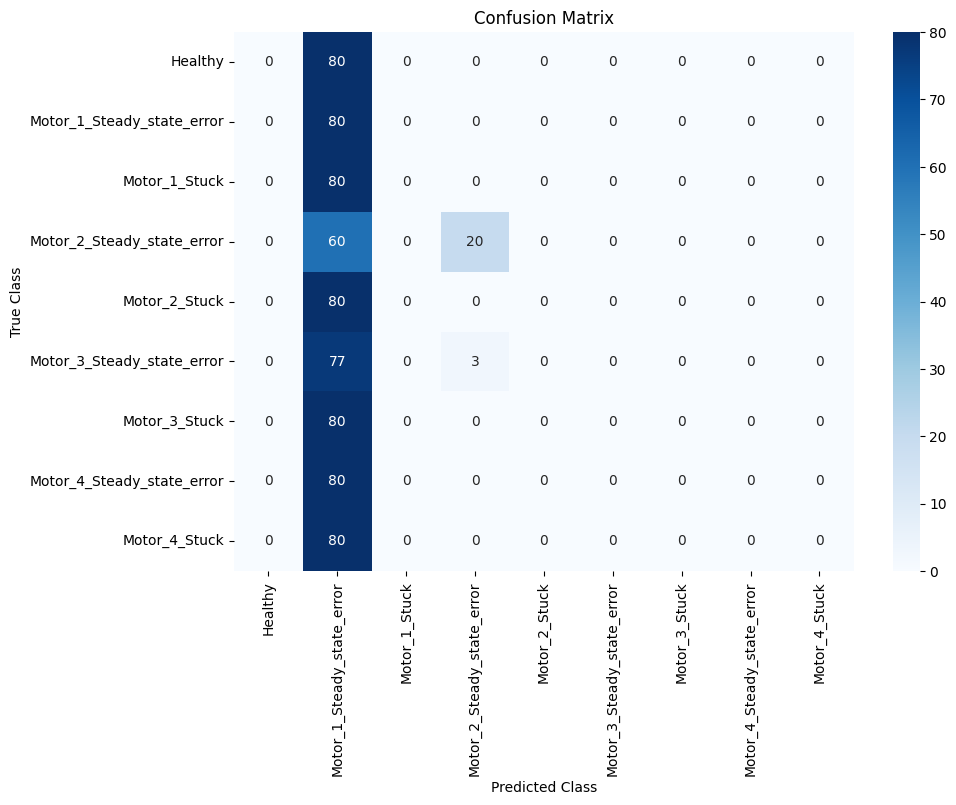

Weighted F1 Score: 0.0660299689425903


In [28]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check if MPS is available and set the device
device = torch.device("cpu") #CPU as LSTM, sequential 
logging.info(f"Using device: {device}")

# Define the features and target
X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Apply StandardScaler to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group the data by sequences based on the Timestamps column
sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Ensure each sequence has the same length
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]

# Pad sequences to make them uniform in length
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        labels.extend([labels[-1]] * (sequence_length - len(labels)))  # Pad labels with the last label
    padded_sequences.append(seq)
    padded_labels.append(labels)  # Use all labels for the sequence

# Convert sequences to a DataFrame
X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)

# Flatten the labels to match the number of sequences
y_padded_flat = y_padded[:, 0]  # Use the first label of each sequence for simplicity

# Split the dataset
training_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

# Ensure the reshaped data has the correct number of samples
assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1), not using softmax as CrossEntropyLoss already applies it

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x)
        return x

# Hyperparameters
input_size = num_features  # Number of features per time step
hidden_size = 200
output_size = y_train_encoded.shape[1]
num_epochs = 50
learning_rate = 0.001
early_stopping_patience = 5

# Initialize the model, loss function, and optimizer
model = LSTMClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
history = {'train_loss': [], 'val_loss': [], 'grad_norm': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    grad_norms = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()

        # Calculate gradient norm
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_norms.append(grad_norm.item())

        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_grad_norm = np.mean(grad_norms)
    history['train_loss'].append(avg_train_loss)
    history['grad_norm'].append(avg_grad_norm)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)

    info_str = (f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Grad Norm: {avg_grad_norm:.4f}")
    logging.info(info_str)
    print(info_str)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['grad_norm'], label='Grad Norm')
plt.xlabel('Epoch')
plt.ylabel('Grad Norm')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model and obtain predictions (raw logits)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    # Use raw logits directly for ROC computation (ordering is preserved)
    y_pred_logits = y_pred.cpu().numpy()
    # Ground truth is one-hot encoded in y_test_tensor
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curve and AUC for each class using one-vs-rest approach
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for every class on one plot
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):  # using original class names
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# For the confusion matrix and classification report, convert predictions to class indices
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Print the classification report with original class names
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

# Plot the confusion matrix with real class names on the axes
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print Weighted F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


# BiLSTM + Attention

2025-02-23 20:18:46,239 - INFO - Using device: cpu
2025-02-23 20:21:03,839 - INFO - Epoch 1: Train Loss: 2.0583, Val Loss: 1.8349
2025-02-23 20:21:03,845 - INFO - Best model saved.


Epoch 1: Train Loss: 2.0583, Val Loss: 1.8349


2025-02-23 20:23:11,017 - INFO - Epoch 2: Train Loss: 1.6752, Val Loss: 1.5386
2025-02-23 20:23:11,023 - INFO - Best model saved.


Epoch 2: Train Loss: 1.6752, Val Loss: 1.5386


2025-02-23 20:25:16,170 - INFO - Epoch 3: Train Loss: 1.6964, Val Loss: 1.4893
2025-02-23 20:25:16,175 - INFO - Best model saved.


Epoch 3: Train Loss: 1.6964, Val Loss: 1.4893


2025-02-23 20:27:28,760 - INFO - Epoch 4: Train Loss: 1.3806, Val Loss: 1.3054
2025-02-23 20:27:28,766 - INFO - Best model saved.


Epoch 4: Train Loss: 1.3806, Val Loss: 1.3054


2025-02-23 20:29:40,837 - INFO - Epoch 5: Train Loss: 1.2690, Val Loss: 1.1560
2025-02-23 20:29:40,846 - INFO - Best model saved.


Epoch 5: Train Loss: 1.2690, Val Loss: 1.1560


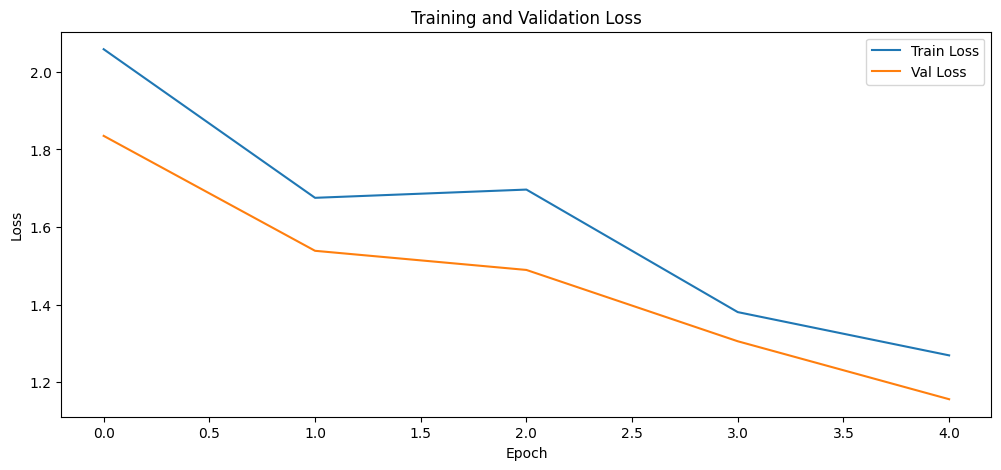

/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_64313/75911464.py:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


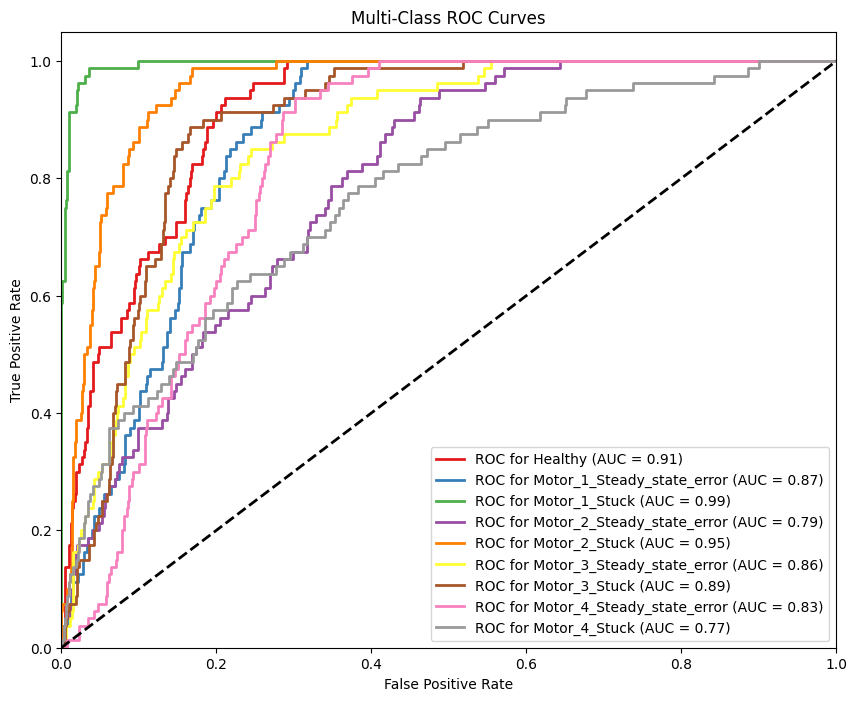

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.21      0.07      0.11        80
Motor_1_Steady_state_error       0.32      0.90      0.47        80
             Motor_1_Stuck       0.84      0.96      0.90        80
Motor_2_Steady_state_error       0.42      0.72      0.53        80
             Motor_2_Stuck       0.72      0.64      0.68        80
Motor_3_Steady_state_error       0.58      0.47      0.52        80
             Motor_3_Stuck       0.58      0.53      0.55        80
Motor_4_Steady_state_error       0.45      0.11      0.18        80
             Motor_4_Stuck       0.50      0.04      0.07        80

                  accuracy                           0.49       720
                 macro avg       0.51      0.49      0.45       720
              weighted avg       0.51      0.49      0.45       720



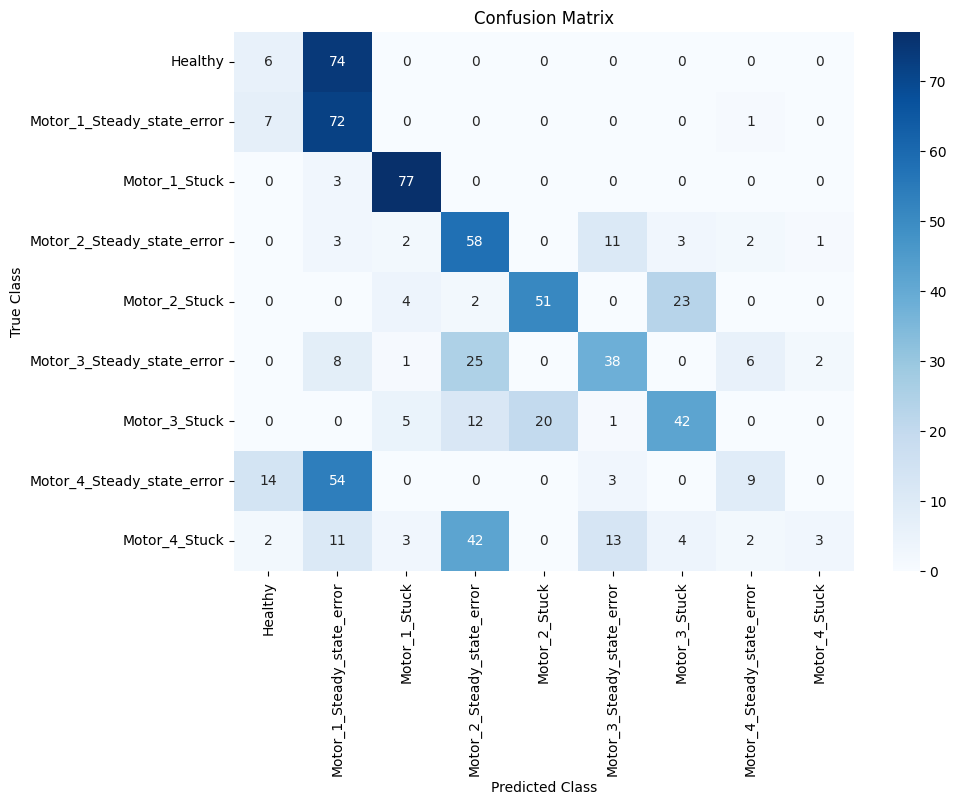

Weighted F1 Score: 0.4450773053245989


In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device("cpu")  # Using CPU for this example; change to 'cuda' if GPU is available
logging.info(f"Using device: {device}")


X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    # Assuming a new sequence starts when the next timestamp equals 0.0
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Determine the maximum sequence length and pad sequences
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        # Pad labels with the last label of the sequence
        labels.extend([labels[-1]] * (sequence_length - len(labels)))
    padded_sequences.append(seq)
    padded_labels.append(labels)

X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)
# For simplicity, we use the first label of each sequence as the label for that sequence
y_padded_flat = y_padded[:, 0]


training_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat
)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class BiLSTMAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(BiLSTMAttentionClassifier, self).__init__()
        # Bidirectional LSTM layers
        self.bilstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        # Attention mechanism: computes a weight for each time step, next time positional encoding?
        self.attention = nn.Linear(hidden_size * 2, 1)
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        # LSTM output: shape (batch, seq_len, hidden_size*2)
        lstm_out, _ = self.bilstm(x)
        # Compute attention weights along the sequence
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # shape: (batch, seq_len, 1)
        # Weighted sum of LSTM outputs using attention
        attn_applied = torch.sum(lstm_out * attn_weights, dim=1)  # shape: (batch, hidden_size*2)
        # Final classification
        output = self.fc(attn_applied)
        return output


input_size = num_features
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 5
learning_rate = 0.001
early_stopping_patience = 5

model = BiLSTMAttentionClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


history = {'train_loss': [], 'val_loss': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)
    
    info_str = f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
    logging.info(info_str)
    print(info_str)
    
    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break


plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_logits = y_pred.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curves and AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Convert predictions to class indices for confusion matrix and classification report
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)


2025-02-23 20:58:53,559 - INFO - Using device: cpu
2025-02-23 21:00:33,846 - INFO - Epoch 1: Train Loss: 2.0833, Val Loss: 1.8775
2025-02-23 21:00:33,849 - INFO - Best model saved.


Epoch 1: Train Loss: 2.0833, Val Loss: 1.8775


2025-02-23 21:02:03,048 - INFO - Epoch 2: Train Loss: 1.8220, Val Loss: 1.6460
2025-02-23 21:02:03,051 - INFO - Best model saved.


Epoch 2: Train Loss: 1.8220, Val Loss: 1.6460


2025-02-23 21:03:31,438 - INFO - Epoch 3: Train Loss: 1.6049, Val Loss: 1.4993
2025-02-23 21:03:31,441 - INFO - Best model saved.


Epoch 3: Train Loss: 1.6049, Val Loss: 1.4993


2025-02-23 21:05:01,074 - INFO - Epoch 4: Train Loss: 1.2484, Val Loss: 1.1225
2025-02-23 21:05:01,076 - INFO - Best model saved.


Epoch 4: Train Loss: 1.2484, Val Loss: 1.1225


2025-02-23 21:06:29,899 - INFO - Epoch 5: Train Loss: 1.0664, Val Loss: 0.9890
2025-02-23 21:06:29,902 - INFO - Best model saved.


Epoch 5: Train Loss: 1.0664, Val Loss: 0.9890


2025-02-23 21:07:59,284 - INFO - Epoch 6: Train Loss: 0.9380, Val Loss: 0.9399
2025-02-23 21:07:59,286 - INFO - Best model saved.


Epoch 6: Train Loss: 0.9380, Val Loss: 0.9399


2025-02-23 21:09:27,227 - INFO - Epoch 7: Train Loss: 0.9196, Val Loss: 1.0304


Epoch 7: Train Loss: 0.9196, Val Loss: 1.0304


2025-02-23 21:10:56,406 - INFO - Epoch 8: Train Loss: 0.8967, Val Loss: 0.8487
2025-02-23 21:10:56,409 - INFO - Best model saved.


Epoch 8: Train Loss: 0.8967, Val Loss: 0.8487


2025-02-23 21:12:25,587 - INFO - Epoch 9: Train Loss: 0.7681, Val Loss: 0.7261
2025-02-23 21:12:25,589 - INFO - Best model saved.


Epoch 9: Train Loss: 0.7681, Val Loss: 0.7261


2025-02-23 21:13:55,179 - INFO - Epoch 10: Train Loss: 0.6484, Val Loss: 0.6891
2025-02-23 21:13:55,181 - INFO - Best model saved.


Epoch 10: Train Loss: 0.6484, Val Loss: 0.6891


2025-02-23 21:15:25,497 - INFO - Epoch 11: Train Loss: 0.7218, Val Loss: 1.4691


Epoch 11: Train Loss: 0.7218, Val Loss: 1.4691


2025-02-23 21:16:55,384 - INFO - Epoch 12: Train Loss: 0.9938, Val Loss: 0.7790


Epoch 12: Train Loss: 0.9938, Val Loss: 0.7790


2025-02-23 21:18:26,291 - INFO - Epoch 13: Train Loss: 0.7152, Val Loss: 0.6667
2025-02-23 21:18:26,293 - INFO - Best model saved.


Epoch 13: Train Loss: 0.7152, Val Loss: 0.6667


2025-02-23 21:19:56,043 - INFO - Epoch 14: Train Loss: 0.6373, Val Loss: 0.6856


Epoch 14: Train Loss: 0.6373, Val Loss: 0.6856


2025-02-23 21:21:24,032 - INFO - Epoch 15: Train Loss: 0.9872, Val Loss: 1.0941


Epoch 15: Train Loss: 0.9872, Val Loss: 1.0941


2025-02-23 21:22:50,876 - INFO - Epoch 16: Train Loss: 0.9878, Val Loss: 0.9062


Epoch 16: Train Loss: 0.9878, Val Loss: 0.9062


2025-02-23 21:24:19,118 - INFO - Epoch 17: Train Loss: 0.7584, Val Loss: 0.8274


Epoch 17: Train Loss: 0.7584, Val Loss: 0.8274


2025-02-23 21:25:46,881 - INFO - Epoch 18: Train Loss: 0.6762, Val Loss: 0.6168
2025-02-23 21:25:46,883 - INFO - Best model saved.


Epoch 18: Train Loss: 0.6762, Val Loss: 0.6168


2025-02-23 21:27:15,957 - INFO - Epoch 19: Train Loss: 0.5547, Val Loss: 0.6158
2025-02-23 21:27:15,959 - INFO - Best model saved.


Epoch 19: Train Loss: 0.5547, Val Loss: 0.6158


2025-02-23 21:28:44,171 - INFO - Epoch 20: Train Loss: 0.9818, Val Loss: 1.2591


Epoch 20: Train Loss: 0.9818, Val Loss: 1.2591


2025-02-23 21:30:13,917 - INFO - Epoch 21: Train Loss: 0.8586, Val Loss: 0.6436


Epoch 21: Train Loss: 0.8586, Val Loss: 0.6436


2025-02-23 21:31:41,004 - INFO - Epoch 22: Train Loss: 0.5725, Val Loss: 0.6251


Epoch 22: Train Loss: 0.5725, Val Loss: 0.6251


2025-02-23 21:33:09,802 - INFO - Epoch 23: Train Loss: 0.5299, Val Loss: 0.5014
2025-02-23 21:33:09,804 - INFO - Best model saved.


Epoch 23: Train Loss: 0.5299, Val Loss: 0.5014


2025-02-23 21:34:39,051 - INFO - Epoch 24: Train Loss: 0.5446, Val Loss: 0.4723
2025-02-23 21:34:39,053 - INFO - Best model saved.


Epoch 24: Train Loss: 0.5446, Val Loss: 0.4723


2025-02-23 21:36:09,234 - INFO - Epoch 25: Train Loss: 0.4375, Val Loss: 0.5149


Epoch 25: Train Loss: 0.4375, Val Loss: 0.5149


2025-02-23 21:37:39,567 - INFO - Epoch 26: Train Loss: 0.4170, Val Loss: 0.4441
2025-02-23 21:37:39,569 - INFO - Best model saved.


Epoch 26: Train Loss: 0.4170, Val Loss: 0.4441


2025-02-23 21:39:07,955 - INFO - Epoch 27: Train Loss: 0.4632, Val Loss: 0.4905


Epoch 27: Train Loss: 0.4632, Val Loss: 0.4905


2025-02-23 21:40:37,867 - INFO - Epoch 28: Train Loss: 0.3837, Val Loss: 0.3922
2025-02-23 21:40:37,869 - INFO - Best model saved.


Epoch 28: Train Loss: 0.3837, Val Loss: 0.3922


2025-02-23 21:42:07,788 - INFO - Epoch 29: Train Loss: 0.3672, Val Loss: 0.3617
2025-02-23 21:42:07,790 - INFO - Best model saved.


Epoch 29: Train Loss: 0.3672, Val Loss: 0.3617


2025-02-23 21:43:40,127 - INFO - Epoch 30: Train Loss: 0.3530, Val Loss: 0.4103


Epoch 30: Train Loss: 0.3530, Val Loss: 0.4103


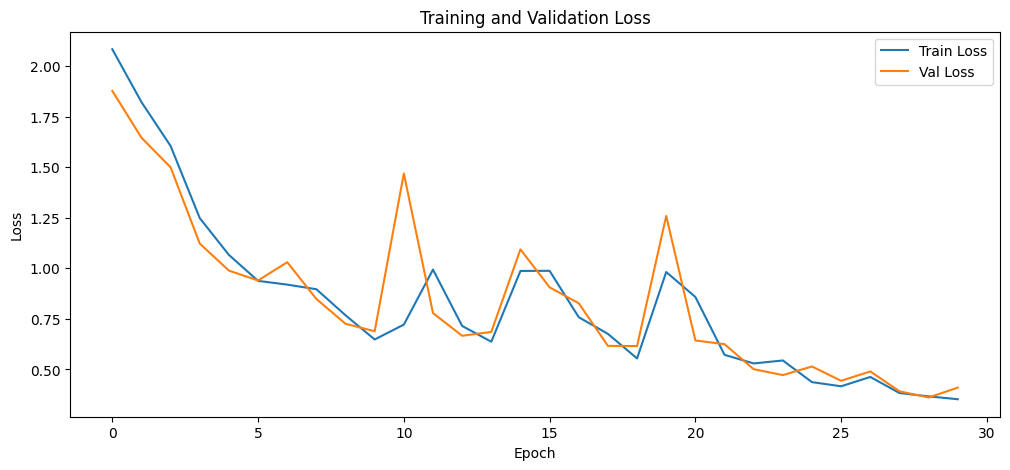

/var/folders/yh/_ppgrc3d53l5n5915g7yfq040000gn/T/ipykernel_64313/644061695.py:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


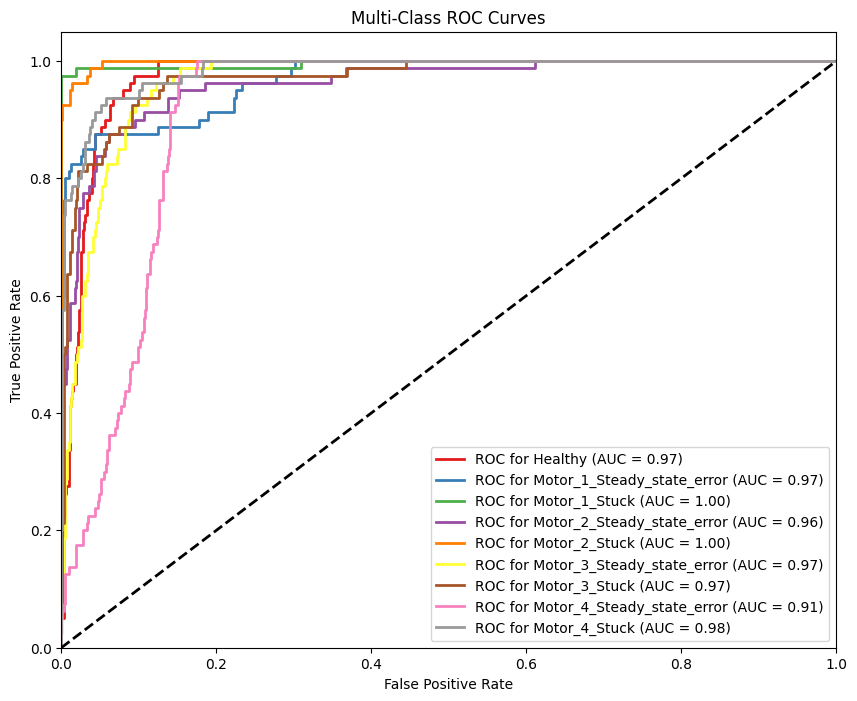

Classification Report:
                             precision    recall  f1-score   support

                   Healthy       0.68      0.84      0.75        80
Motor_1_Steady_state_error       0.95      0.89      0.92        80
             Motor_1_Stuck       1.00      0.97      0.99        80
Motor_2_Steady_state_error       0.80      0.88      0.84        80
             Motor_2_Stuck       0.99      0.95      0.97        80
Motor_3_Steady_state_error       0.87      0.69      0.77        80
             Motor_3_Stuck       0.91      0.93      0.92        80
Motor_4_Steady_state_error       0.66      0.64      0.65        80
             Motor_4_Stuck       0.86      0.89      0.87        80

                  accuracy                           0.85       720
                 macro avg       0.86      0.85      0.85       720
              weighted avg       0.86      0.85      0.85       720



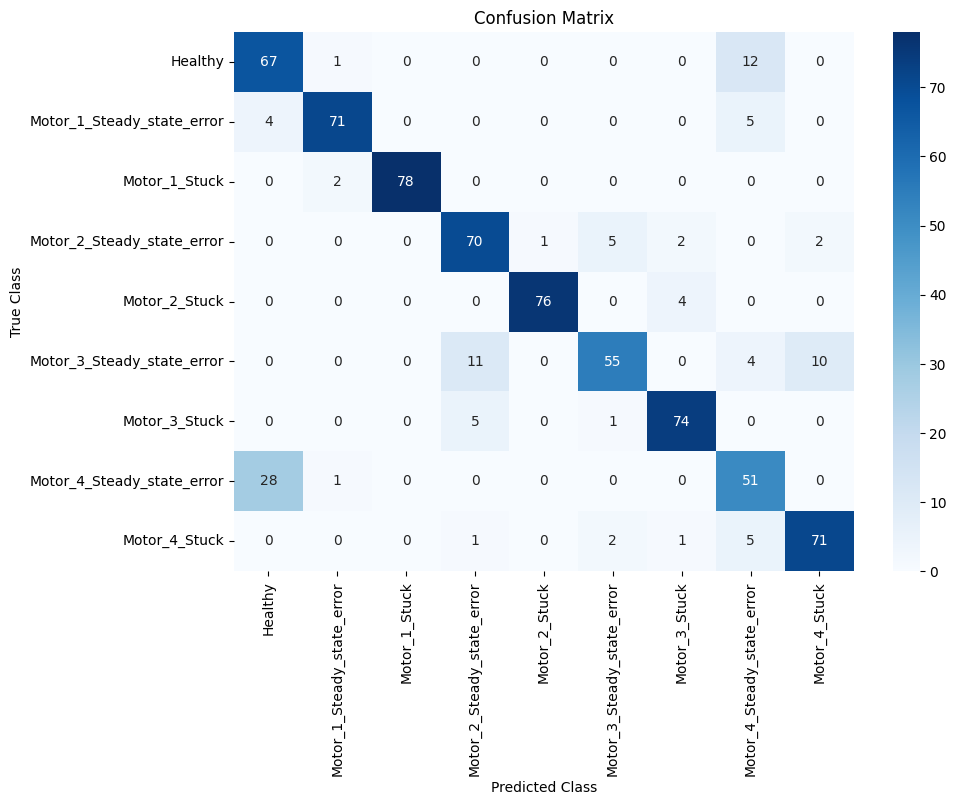

Weighted F1 Score: 0.8519869973723093


In [29]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device("cpu")  # Using CPU for this example; change to 'cuda' if GPU is available
logging.info(f"Using device: {device}")


X = df.drop(columns=['Target', 'Timestamps'])
y = df['Target']
timestamps = df['Timestamps']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


sequences = []
current_sequence = []
current_labels = []
for i in range(len(X_scaled)):
    current_sequence.append(X_scaled[i])
    current_labels.append(y.iloc[i])
    # Assuming a new sequence starts when the next timestamp equals 0.0
    if i < len(X_scaled) - 1 and timestamps.iloc[i + 1] == 0.0:
        sequences.append((current_sequence, current_labels))
        current_sequence = []
        current_labels = []
if current_sequence:
    sequences.append((current_sequence, current_labels))

# Determine the maximum sequence length and pad sequences
sequence_length = max(len(seq[0]) for seq in sequences)
num_features = X.shape[1]
padded_sequences = []
padded_labels = []
for seq, labels in sequences:
    if len(seq) < sequence_length:
        padding = [[0] * num_features] * (sequence_length - len(seq))
        seq.extend(padding)
        # Pad labels with the last label of the sequence
        labels.extend([labels[-1]] * (sequence_length - len(labels)))
    padded_sequences.append(seq)
    padded_labels.append(labels)

X_padded = np.array(padded_sequences)
y_padded = np.array(padded_labels)
# For simplicity, we use the first label of each sequence as the label for that sequence
y_padded_flat = y_padded[:, 0]


training_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_padded_flat, test_size=(1 - training_ratio), stratify=y_padded_flat
)

# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

assert X_train.shape[0] == y_train_encoded.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test_encoded.shape[0], "Mismatch in number of test samples"

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class BiLSTMAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(BiLSTMAttentionClassifier, self).__init__()
        # Bidirectional LSTM layers
        self.bilstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        # Attention mechanism: computes a weight for each time step, next time positional encoding?
        self.attention = nn.Linear(hidden_size * 2, 1)
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        # LSTM output: shape (batch, seq_len, hidden_size*2)
        lstm_out, _ = self.bilstm(x)
        # Compute attention weights along the sequence
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # shape: (batch, seq_len, 1)
        # Weighted sum of LSTM outputs using attention
        attn_applied = torch.sum(lstm_out * attn_weights, dim=1)  # shape: (batch, hidden_size*2)
        # Final classification
        output = self.fc(attn_applied)
        return output


input_size = num_features
hidden_size = 100
output_size = y_train_encoded.shape[1]
num_epochs = 30
learning_rate = 0.001
early_stopping_patience = 5

model = BiLSTMAttentionClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


history = {'train_loss': [], 'val_loss': []}
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_loader)
    history['val_loss'].append(avg_val_loss)
    
    info_str = f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
    logging.info(info_str)
    print(info_str)
    
    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        logging.info("Best model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break


plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_logits = y_pred.cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

# Compute ROC curves and AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1', n_classes)
for i, class_name in enumerate(encoder.categories_[0]):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC for {class_name} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Convert predictions to class indices for confusion matrix and classification report
y_pred_classes = np.argmax(y_pred_logits, axis=1)
y_test_classes = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Classification Report:\n", 
      classification_report(y_test_classes, y_pred_classes, target_names=encoder.categories_[0]))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0],
            yticklabels=encoder.categories_[0])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print("Weighted F1 Score:", f1)
